In [4]:
### Utils

from torchvision.datasets import CIFAR10
from torchvision import transforms

def get_cifar10_dataset(root="data", train=False, transform=False, download=False):
    return CIFAR10(root=root, train=train, transform=transforms.Compose([transforms.ToTensor()]), download=download)




In [ ]:
from accelerate import Accelerator

# Example usage:if __name__ == "__main__":
dataset = get_cifar10_dataset(root='./data', train=True, download=True)
# print(f"Number of training samples: {len(dataset)}") 

# # init_logger(accelerator)
accelerator = Accelerator(split_batches=True)
train_set = get_cifar10_dataset(train=True, download=accelerator.is_local_main_process)
validation_set = get_cifar10_dataset(train=False, download=False)
print(f"Number of training samples: {len(train_set)}") 
print(f"Number of validation samples: {len(validation_set)}") 

Number of training samples: 50000
Number of validation samples: 10000


Training image shape: torch.Size([3, 32, 32])
Validation image shape: torch.Size([3, 32, 32])


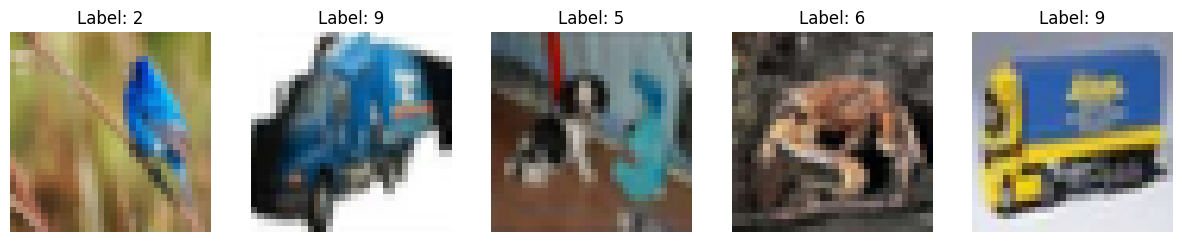

In [11]:
# see data shape and resolution
train_set[0][0].shape, validation_set[0][0].shape
print(f"Training image shape: {train_set[0][0].shape}")
print(f"Validation image shape: {validation_set[0][0].shape}")

# plot random samples from the dataset
import matplotlib.pyplot as plt
import numpy as np
def plot_random_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

plot_random_samples(train_set, num_samples=5)

In [ ]:
import torch
## VARIABLES
IMBEDDEDDING_DIM = 128
NUM_RESNET_BLOCKS = 4
CHANNELS = 3
IMAGE_SIZE = 32
N_ATTENTION_HEADS = 1
N_CHANNELS = 1
NORM_GROUPS = 32

# Create U-net model
from torch import nn
class UNet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        attention_parameters = dict(
            n_heads=N_ATTENTION_HEADS,
            n_channels=IMBEDDEDDING_DIM,
            norm_groups=NORM_GROUPS,
        )
        resnet_parameters = dict(
            ch_in=IMBEDDEDDING_DIM,
            ch_out=IMBEDDEDDING_DIM,
            condition_dim=4 * IMBEDDEDDING_DIM,
            norm_num_groups=NORM_GROUPS,   
        )

        self.embed_conditioning = nn.Sequential(
            nn.Linear(IM, cfg.embedding_dim * 4),
            nn.SiLU(),
            nn.Linear(cfg.embedding_dim * 4, cfg.embedding_dim * 4),
            nn.SiLU(),
        )

    def forward(self, x):
        # Define forward pass here
        pass    



class ResNetBlock(nn.Module):
    def __init__(self, in_channels=IMBEDDEDDING_DIM, out_channels=None, condition_dim=None, norm_num_groups=32):
        super().__init__()
        out_channels = out_channels or in_channels
        self.out_channels = out_channels
        self.condition_dim = 4 * IMBEDDEDDING_DIM
        self.net1 = nn.Sequential(
            nn.GroupNorm(norm_num_groups, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        self.net2 = nn.Sequential(
            nn.GroupNorm(norm_num_groups, out_channels),
            nn.SiLU(), 
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        if in_channels != out_channels:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def zero_init(self, module:nn.Module):
        for p in module.parameters():
            nn.init.zeros_(p.data)
        return module
    
    def cond_proj(self):
        return self.zero_init(nn.Linear(IMBEDDEDDING_DIM, self.out_channels))

    def forward(self, x, condition):
        h = self.net1(x)
        if condition is not None:
            assert condition.shape == (x.shape[0], self.condition_dim)
            condition = self.cond_proj(condition)
            condition = condition[:,:, None, None]
            h = h + condition

        h = self.net2(h)
        if x.shape[1] != self.out_channels:
            x = self.shortcut_conv(x)
        assert x.shape == h.shape
        return x + h
    


    #### WHAT IT DO?
    def get_timestep_embedding(
        timesteps,
        embedding_dim: int,
        dtype=torch.float32,
        max_timescale=10_000,
        min_timescale=1,
    ):
        # Adapted from tensor2tensor and VDM codebase.
        assert timesteps.ndim == 1
        assert embedding_dim % 2 == 0
        timesteps *= 1000.0  # In DDPM the time step is in [0, 1000], here [0, 1]
        num_timescales = embedding_dim // 2
        inv_timescales = torch.logspace(  # or exp(-linspace(log(min), log(max), n))
            -np.log10(min_timescale),
            -np.log10(max_timescale),
            num_timescales,
            device=timesteps.device,
        )
        emb = timesteps.to(dtype)[:, None] * inv_timescales[None, :]  # (T, D/2)
        return torch.cat([emb.sin(), emb.cos()], dim=1)  # (T, D)

        

SyntaxError: '(' was never closed (4036222284.py, line 21)